In [1]:
import pandas as pd
import numpy as np
import gzip
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
%matplotlib inline
sns.set_theme()

# Reading data from the csv.gz files

In [2]:
PATH_BCN = "../data/bcn/"
PATH_MAD = "../data/mad/"

calendar_bcn = pd.read_csv(PATH_BCN+'calendar.csv.gz', compression='gzip')
listings_bcn = pd.read_csv(PATH_BCN+'listings.csv.gz', compression='gzip')
reviews_bcn = pd.read_csv(PATH_BCN+'reviews.csv.gz', compression='gzip')


calendar_mad = pd.read_csv(PATH_MAD+'calendar.csv.gz', compression='gzip')
listings_mad = pd.read_csv(PATH_MAD+'listings.csv.gz', compression='gzip')
reviews_mad = pd.read_csv(PATH_MAD+'reviews.csv.gz', compression='gzip')




In [3]:
listings_bcn.shape, listings_mad.shape

((19641, 74), (20352, 74))

# Preprocessing the different files

## Formating date

In [4]:
def fromString2Date(df, columName):
    timeCol = pd.to_datetime(df[columName],infer_datetime_format=True)
    df.insert(1, "datetime", timeCol)
    df.drop(columName, axis=1, inplace=True)

In [5]:
fromString2Date(calendar_bcn, "date")
fromString2Date(listings_bcn, "last_scraped")
fromString2Date(reviews_bcn, "date")

fromString2Date(calendar_mad, "date")
fromString2Date(listings_mad, "last_scraped")
fromString2Date(reviews_mad, "date")



## Availability format

In [6]:
boolLambda = lambda x:True if x=='t' else False if type(x) == str else x
calendar_bcn.available = calendar_bcn.available.apply(boolLambda)
calendar_mad.available = calendar_mad.available.apply(boolLambda)

## Price format and filtering

In [7]:
priceLambda = lambda x:(float(x.replace(",", "")[1:-3])if ',' in x else float(x[1:-3])) if type(x) == str else x
def fromDollars2Float(df, columnName):
    df[columnName] = df[columnName].apply(priceLambda)

In [8]:
fromDollars2Float(calendar_bcn, 'price')
fromDollars2Float(calendar_bcn, 'adjusted_price')
fromDollars2Float(listings_bcn, 'price')


fromDollars2Float(calendar_mad, 'price')
fromDollars2Float(calendar_mad, 'adjusted_price')
fromDollars2Float(listings_mad, 'price')

In [9]:
calendar_bcn = calendar_bcn.dropna(subset=['price'])
calendar_bcn = calendar_bcn[calendar_bcn.price > 0]
listings_bcn = listings_bcn[listings_bcn.price > 0]

calendar_mad = calendar_mad.dropna(subset=['price'])
calendar_mad = calendar_mad[calendar_mad.price > 0]
listings_mad = listings_mad[listings_mad.price > 0]

## Amenities formatting, from list to columns 

In [10]:
def fromList2Columns(df):
    new_df = df.copy()
    wifi_count = 0
    addedAmenities = []
    dfTotals = pd.Series(dtype="float64")
    if "amenities" in new_df.columns:
        for (i,row) in df.iterrows():
            amenities = row.amenities[1:-1].replace('"', '').split(", ")
            numAmenities = 0
            for amenity in amenities:
                if amenity not in addedAmenities:
                    new_df['amenity_'+amenity] = 0
                    new_df.at[i,'amenity_'+amenity]=1
                    addedAmenities.append(amenity)
                    dfTotals[amenity]=1
                else:
                    new_df.at[i,'amenity_'+amenity]=1
                    dfTotals[amenity]+=1
                numAmenities += 1
                
            if i == 0:
                new_df['NumAmenities'] = 0
            new_df.at[i, 'NumAmenities'] = numAmenities
            
#         new_df.drop(columns=['amenities'], inplace=True)
    return new_df, dfTotals/i

In [11]:
bcn_cpy = listings_bcn.copy()
mad_cpy = listings_mad.copy()

In [12]:
listings_bcn, amTotals_bcn = fromList2Columns(bcn_cpy)

listings_mad, amTotals_mad = fromList2Columns(mad_cpy)

In [13]:
#Debugging
amTotals_bcn.Wifi, listings_bcn.amenity_Wifi.sum()

(0.9688391038696538, 19028)

## Availability formating 

In [16]:
listings_bcn['occupacy_30days'] = 1-(listings_bcn.availability_30/30)
listings_mad['occupacy_30days'] = 1-(listings_mad.availability_30/30)

## Score calculation

In [17]:
scoreCols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
             'review_scores_communication','review_scores_location', 'review_scores_value']
listings_bcn['Score'] = listings_bcn[scoreCols].mean(axis=1)

listings_mad['Score'] = listings_mad[scoreCols].mean(axis=1)

## Removing price outliers

In [18]:
#Percentage of accomodations above 500$
thr = 200
print("Barcelona > 1000$: ", str((listings_bcn.price>thr).mean()*100)+"%")
print("Madrid > 1000$: ", str((listings_mad.price>thr).mean()*100)+"%")

Barcelona > 1000$:  6.385904160513317%
Madrid > 1000$:  8.537304629902684%


In [19]:
listings_bcn = listings_bcn[listings_bcn.price<=thr]
listings_mad = listings_mad[listings_mad.price<=thr]

In [20]:
listID_bcn = listings_bcn.id.unique()
calendar_bcn = calendar_bcn[calendar_bcn.listing_id.isin(listID_bcn)]

listID_mad = listings_mad.id.unique()
calendar_mad = calendar_mad[calendar_mad.listing_id.isin(listID_mad)]

# Question1: Are the Airbnb prices more or less expensive than the average price of an hotel in Barcelona or Madrid?

Reference Page: https://www.budgetyourtrip.com/

Average price of a hotel in Barcelona is **177**dollars per couple, which results on **88.5**dollars per person/night

Average price of a hotel in Madrid is **130**dollars per a couple, which results on **65**dollars per person/night

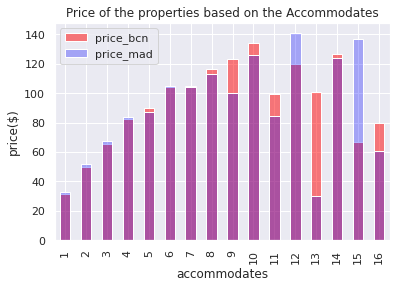

In [21]:
meanPriceAmenities_bcn = listings_bcn.groupby(by='accommodates').price.mean()

meanPriceAmenities_mad = listings_mad.groupby(by='accommodates').price.mean()

meanPriceAmenities_bcn.plot.bar(label='price_bcn', color=(1, 0, 0, 0.5))
meanPriceAmenities_mad.plot.bar(label='price_mad', color=(0,0,1,0.3))

plt.title("Price of the properties based on the Accommodates")
plt.legend(loc='upper left')
plt.ylabel('price($)')
plt.plot();

From this plot is possible to see that the either Madrid and Barcelona is better to rent an apartment for Airbnb as for a couple the price per night is under **100**dollars. Is shows that Madrid is more expensive on most of the accommodation sizes. For accommodations with more than 13 people is hard to tell as prices from Madrid are way lower than the prices from accommodations that accept less people.

In [22]:
listings_bcn.price.shape[0]

18383

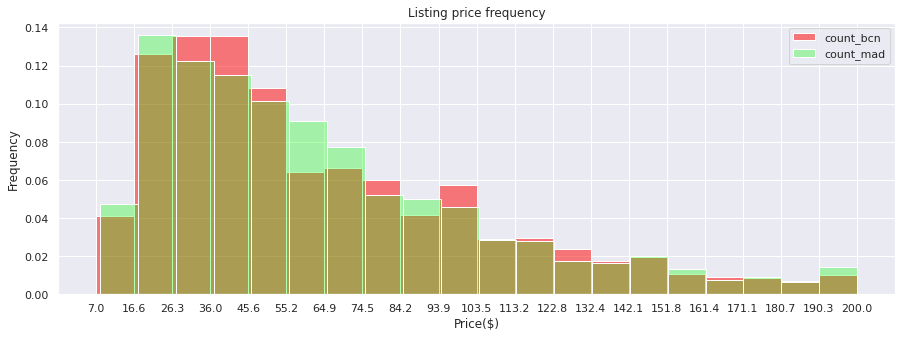

In [23]:
plt.figure(figsize=(15,5))
(_, bins_bcn,_) = plt.hist(listings_bcn.price, bins=20, color=(1, 0, 0, 0.5), 
                           label="count_bcn", 
                           weights=np.ones(listings_bcn.price.shape[0]) / listings_bcn.price.shape[0])

(_, bins_mad,_) = plt.hist(listings_mad.price, bins=20, color=(0,1,0,0.3), 
                           label="count_mad", 
                           weights=np.ones(listings_mad.price.shape[0]) / listings_mad.price.shape[0])
plt.title("Listing price frequency")
plt.xticks(bins_bcn)
plt.ylabel("Frequency")
plt.xlabel("Price($)")
plt.legend()
plt.plot();

In [24]:
listings_bcn.price.describe(), '------Median BCN------ ' ,listings_bcn.price.median()

(count    18383.00000
 mean        63.97601
 std         41.62130
 min          7.00000
 25%         33.00000
 50%         50.00000
 75%         87.00000
 max        200.00000
 Name: price, dtype: float64,
 '------Median BCN------ ',
 50.0)

In [25]:
listings_mad.price.describe(), '------Median BCN------ ' ,listings_mad.price.median()

(count    18609.000000
 mean        64.583212
 std         42.081143
 min          8.000000
 25%         32.000000
 50%         54.000000
 75%         85.000000
 max        200.000000
 Name: price, dtype: float64,
 '------Median BCN------ ',
 54.0)

Most of the accommodations are bellow **300** dollars either in Barcelona and in Madrid.

# Question2: How much will people pay during the year 2021 if they travel to Barcelona or Madrid?

In [26]:
calendar_bcn.head()

,listing_id,datetime,available,price,adjusted_price,minimum_nights,maximum_nights
0,305213,2020-12-18,True,70.0,70.0,20.0,1125.0
1,21974,2020-12-17,False,80.0,80.0,3.0,90.0
2,21974,2020-12-18,False,80.0,80.0,3.0,90.0
3,21974,2020-12-19,False,80.0,80.0,3.0,90.0
4,21974,2020-12-20,False,80.0,80.0,3.0,90.0


In [27]:
calendar_bcn[calendar_bcn.listing_id == 305213]

,listing_id,datetime,available,price,adjusted_price,minimum_nights,maximum_nights
0,305213,2020-12-18,True,70.0,70.0,20.0,1125.0
838,305213,2020-12-19,True,70.0,70.0,20.0,1125.0
839,305213,2020-12-20,True,70.0,70.0,20.0,1125.0
840,305213,2020-12-21,True,70.0,70.0,20.0,1125.0
852,305213,2020-12-22,True,70.0,70.0,20.0,1125.0
...,...,...,...,...,...,...,...
2075,305213,2021-12-13,False,70.0,70.0,20.0,1125.0
2076,305213,2021-12-14,False,70.0,70.0,20.0,1125.0
2077,305213,2021-12-15,False,70.0,70.0,20.0,1125.0
2078,305213,2021-12-16,False,70.0,70.0,20.0,1125.0


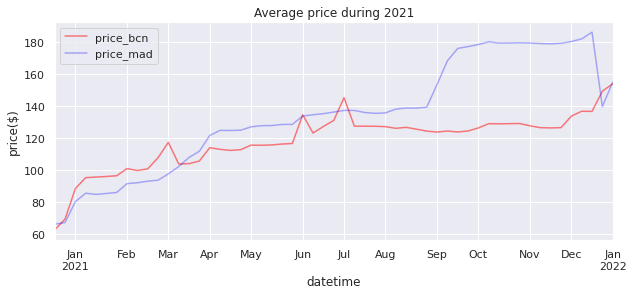

In [28]:
meanPriceDay_bcn = calendar_bcn.groupby(pd.Grouper(key='datetime', freq='1w')).price.mean()

meanPriceDay_mad = calendar_mad.groupby(pd.Grouper(key='datetime', freq='1w')).price.mean()

plt.figure(figsize=(10,4))

meanPriceDay_bcn.plot(label='price_bcn', color=(1, 0, 0, 0.5))
meanPriceDay_mad.plot(label='price_mad', color=(0,0,1,0.3))

plt.title("Average price during 2021")
plt.legend()
plt.ylabel('price($)')
plt.plot();

As previously mentioned, we can see that the prices per accommodants in Madrid where higher, and this can also be seen during this 2021. What is curious about both cities is that the average prices will increase everymonth. In Barcelona, the first week of June and the first week of July will be more expensive as is normally the period where most tourists go for vacations to visit Barcelona city. But there is not a clear trend during the year and this can be due to all the tourist crisis generated by the Coronavirus.

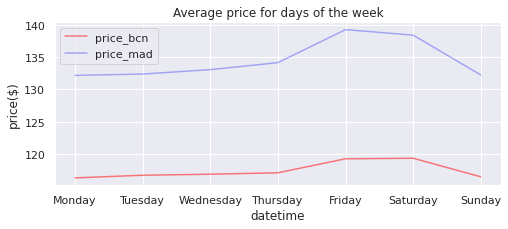

In [29]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
meanPriceWeekDay_bcn = calendar_bcn.groupby(calendar_bcn.datetime.dt.day_name()).price.mean().reindex(days)

meanPriceWeekDay_mad = calendar_mad.groupby(calendar_mad.datetime.dt.day_name()).price.mean().reindex(days)

plt.figure("Barcelona", figsize=(8, 3))
meanPriceWeekDay_bcn.plot(label='price_bcn', color=(1, 0, 0, 0.5))

meanPriceWeekDay_mad.plot(label='price_mad', color=(0,0,1,0.3))

plt.title("Average price for days of the week")
plt.legend()
plt.ylabel('price($)')
plt.plot();

We can confirm that there is a clear trend during the weekends in both cities.

# Question3: What type of accommodations are available and which are the most popular amenities? 

Check **property_type**, **room_type**, **amenities**

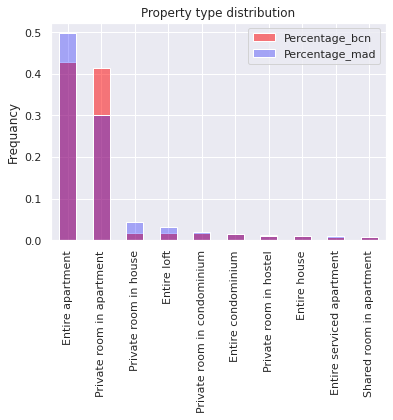

In [72]:
plt.figure()
plt.title("Property type distribution")
bcn_total = listings_bcn.shape[0]
(listings_bcn.property_type.value_counts()/bcn_total)[:10].plot.bar(color=(1, 0, 0, 0.5), label='Percentage_bcn')

mad_total = listings_mad.shape[0]
(listings_mad.property_type.value_counts()/mad_total)[:10].plot.bar(color=(0,0,1,0.3), label='Percentage_mad')
plt.legend()
plt.ylabel("Frequancy")
plt.plot();

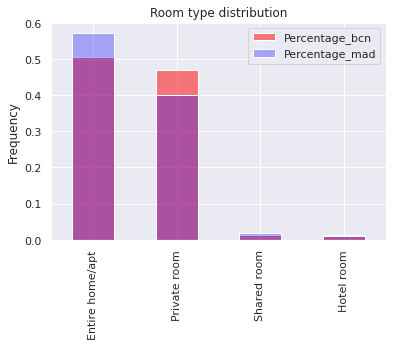

In [71]:
plt.figure()
plt.title("Room type distribution")
bcn_total = listings_bcn.shape[0]
(listings_bcn.room_type.value_counts()/bcn_total).plot.bar(color=(1, 0, 0, 0.5), label='Percentage_bcn')

mad_total = listings_mad.shape[0]
(listings_mad.room_type.value_counts()/mad_total).plot.bar(color=(0,0,1,0.3), label='Percentage_mad')
plt.legend()
plt.ylabel("Frequency")
plt.plot();

In [32]:
amCols_bcn = [col for col in listings_bcn.columns if 'amenity' in col]
amCols_mad = [col for col in listings_mad.columns if 'amenity' in col]

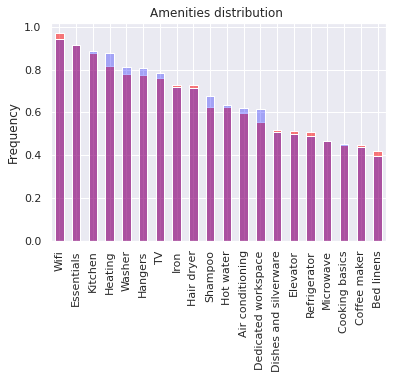

In [33]:
plt.figure()
amTotals_bcn.sort_values(ascending=False).head(n=20).plot.bar(color=(1, 0, 0, 0.5))
plt.ylabel("Frequency")

plt.title("Amenities distribution ")
amTotals_mad.sort_values(ascending=False).head(n=20).plot.bar(color=(0, 0, 1, 0.3))
plt.ylabel("Frequency")
plt.plot();

# Question4: When is the best time to visit Barcelona and Madrid?
Check **availability** per **month**, **next_30_days**

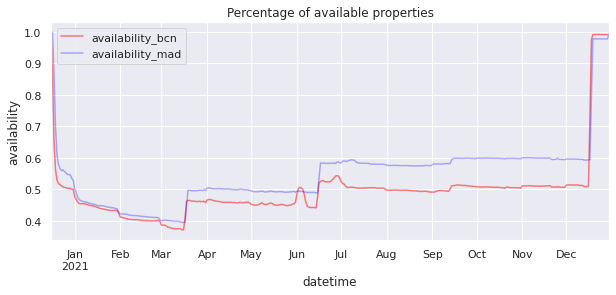

In [34]:
availabilityDay_bcn = 1-(calendar_bcn.groupby(pd.Grouper(key='datetime', freq='1d')).available.sum()/listings_bcn.shape[0])

availabilityDay_mad = 1-(calendar_mad.groupby(pd.Grouper(key='datetime', freq='1d')).available.sum()/listings_mad.shape[0])

plt.figure(figsize=(10,4))
availabilityDay_bcn.plot(label='availability_bcn', color=(1, 0, 0, 0.5))
availabilityDay_mad.plot(label='availability_mad', color=(0, 0, 1, 0.3))

plt.title("Percentage of available properties")
plt.legend()
plt.ylabel('availability')
plt.plot();

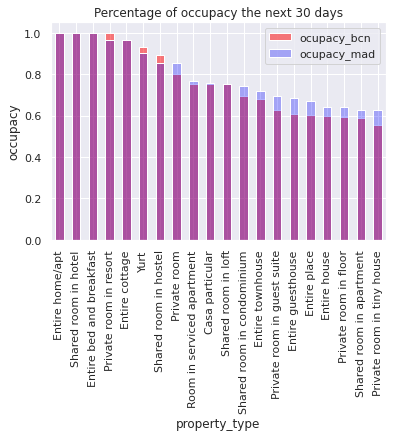

In [35]:
listings_bcn.groupby(by='property_type').occupacy_30days.mean().sort_values(ascending=False).head(n=20).plot.bar(color=(1, 0, 0, 0.5), label='ocupacy_bcn')

listings_mad.groupby(by='property_type').occupacy_30days.mean().sort_values(ascending=False).head(n=20).plot.bar(color=(0, 0, 1, 0.3), label='ocupacy_mad')
plt.title("Percentage of occupacy the next 30 days")
plt.ylabel("occupacy")
plt.legend();

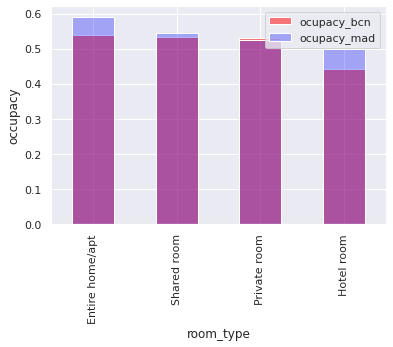

In [70]:
listings_bcn.groupby(by='room_type').occupacy_30days.mean().sort_values(ascending=False).plot.bar(color=(1, 0, 0, 0.5), label='ocupacy_bcn')

listings_mad.groupby(by='room_type').occupacy_30days.mean().sort_values(ascending=False).plot.bar(color=(0, 0, 1, 0.3), label='ocupacy_mad')

plt.ylabel("occupacy")
plt.legend();

# Question5: Which are the most expensive neighbourhoods from both cities? And how popular are they?

Check **neighbourhood** with **price**, number of **accommodations**, **review_rating**

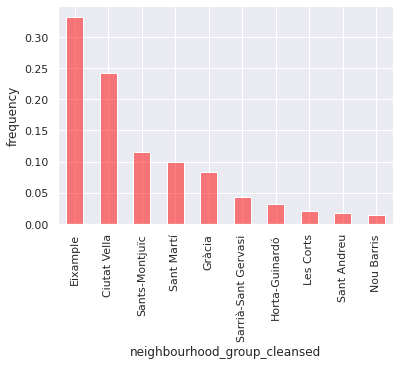

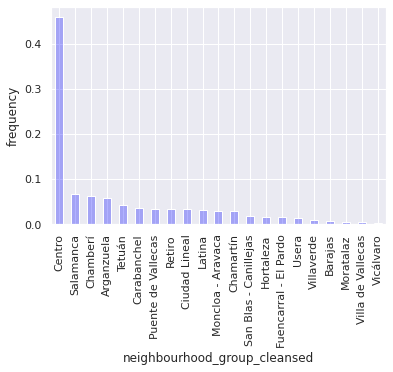

In [68]:
plt.figure("bcn")
(listings_bcn.groupby(by='neighbourhood_group_cleansed').price.count()/listings_bcn.shape[0]).sort_values(ascending=False).plot.bar(color=(1, 0, 0, 0.5))
plt.ylabel("frequency")

plt.figure("mad")
(listings_mad.groupby(by='neighbourhood_group_cleansed').price.count()/listings_bcn.shape[0]).sort_values(ascending=False).plot.bar(color=(0, 0, 1, 0.3))

plt.ylabel("frequency")
plt.plot();

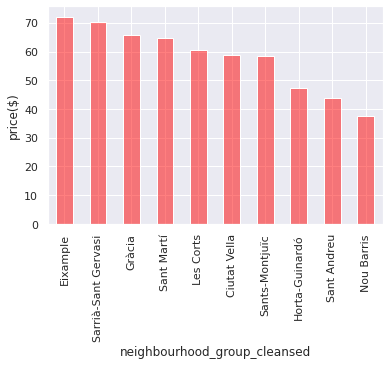

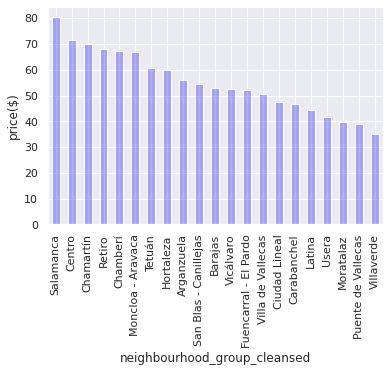

In [69]:
plt.figure("bcn")
listings_bcn.groupby(by='neighbourhood_group_cleansed').price.mean().sort_values(ascending=False).plot.bar(color=(1, 0, 0, 0.5))
plt.ylabel("price($)")

plt.figure("mad")
listings_mad.groupby(by='neighbourhood_group_cleansed').price.mean().sort_values(ascending=False).plot.bar(color=(0, 0, 1, 0.3))
plt.ylabel("price($)")
plt.plot();

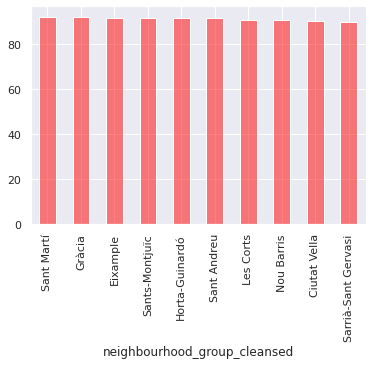

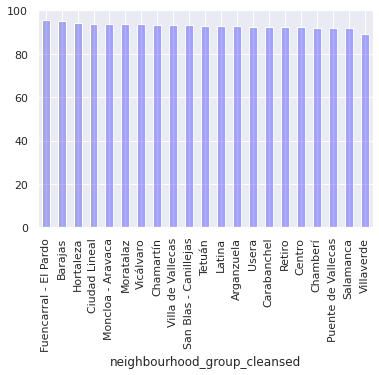

In [42]:
plt.figure("bcn")
dropRev_bcn = listings_bcn.dropna(subset=['review_scores_rating'])
(dropRev_bcn.groupby(by='neighbourhood_group_cleansed').review_scores_rating.mean()).sort_values(ascending=False).plot.bar(color=(1, 0, 0, 0.5))

plt.figure("mad")
dropRev_mad = listings_mad.dropna(subset=['review_scores_rating'])
(dropRev_mad.groupby(by='neighbourhood_group_cleansed').review_scores_rating.mean()).sort_values(ascending=False).plot.bar(color=(0, 0, 1, 0.3))

plt.plot();

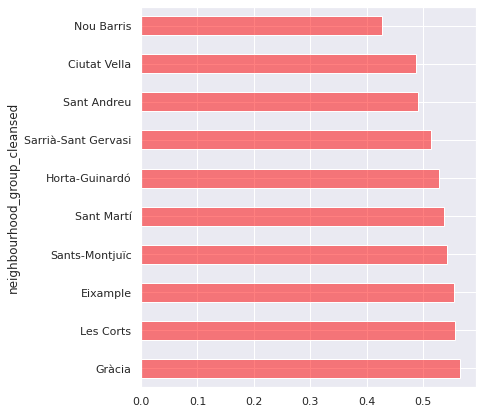

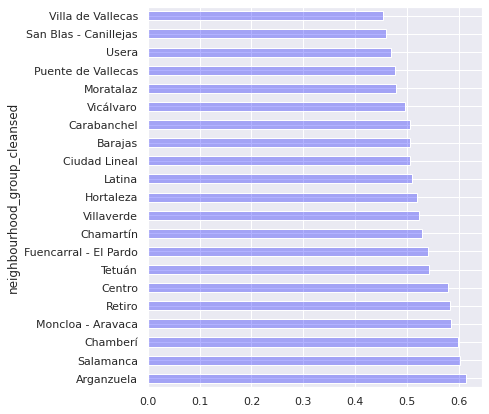

In [43]:
plt.figure("bcn",figsize=(6,7))
listings_bcn.groupby(by='neighbourhood_group_cleansed').occupacy_30days.mean().sort_values(ascending=False).plot.barh(color=(1, 0, 0, 0.5))

plt.figure("mad",figsize=(6,7))
listings_mad.groupby(by='neighbourhood_group_cleansed').occupacy_30days.mean().sort_values(ascending=False).plot.barh(color=(0, 0, 1, 0.3))

plt.plot();

# Question6: Which features better describe the accommodation price?
Build a **regression model** to find the **correlation** of the **independent variables** with the **price**

### Features selection

In [46]:
list_feat = ['host_is_superhost', 'host_listings_count', 
             'host_has_profile_pic', 'latitude', 'longitude', 'accommodates', 'room_type', 
             'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'occupacy_30days', 'number_of_reviews','Score',
             'instant_bookable', 'NumAmenities', 'price']
list_feat_bcn = list_feat.copy()
df_bcn = listings_bcn[list_feat_bcn]

list_feat_mad = list_feat.copy()
df_mad = listings_mad[list_feat_mad]

### Get dummy variables

In [47]:
def getDummyVariables(df, columns):
    df_dummy = pd.get_dummies(df[columns])
    df_drop = df.drop(columns=columns)
    return pd.concat([df_drop,df_dummy], axis=1)

df_dummy_bcn = getDummyVariables(df_bcn, ['room_type'])

df_dummy_mad = getDummyVariables(df_mad, ['room_type'])

df_dummy_mad.head()

,host_is_superhost,host_listings_count,host_has_profile_pic,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,occupacy_30days,number_of_reviews,Score,instant_bookable,NumAmenities,price,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,t,1.0,t,40.45724,-3.67688,2,1.0,1.0,1,1125,0.000000,78,22.571429,f,17,60.0,0,0,1,0
1,f,2.0,t,40.40341,-3.74084,1,1.0,1.0,4,40,0.033333,33,21.000000,f,27,31.0,0,0,1,0
2,f,10.0,t,40.38695,-3.69304,6,3.0,5.0,15,730,1.000000,0,NaN,f,38,60.0,1,0,0,0
3,f,1.0,t,40.42202,-3.70395,3,NaN,1.0,5,730,0.066667,10,22.428571,f,28,101.0,1,0,0,0
4,t,1.0,t,40.41995,-3.69764,4,2.0,3.0,3,10,0.233333,68,22.571429,f,26,115.0,1,0,0,0


### Process boolean variables

In [48]:
df_dummy_bcn.host_is_superhost = df_dummy_bcn.host_is_superhost.apply(boolLambda)
df_dummy_bcn.host_has_profile_pic = df_dummy_bcn.host_has_profile_pic.apply(boolLambda)
df_dummy_bcn.instant_bookable = df_dummy_bcn.instant_bookable.apply(boolLambda)

df_dummy_mad.host_is_superhost = df_dummy_mad.host_is_superhost.apply(boolLambda)
df_dummy_mad.host_has_profile_pic = df_dummy_mad.host_has_profile_pic.apply(boolLambda)
df_dummy_mad.instant_bookable = df_dummy_mad.instant_bookable.apply(boolLambda)

### Columns with NaN values

In [49]:
#Barcelona
df_dummy_bcn.isna().sum()[df_dummy_bcn.isna().sum() > 0]

host_is_superhost          7
host_listings_count        7
host_has_profile_pic       7
bedrooms                 707
beds                     399
Score                   5959
dtype: int64

In [50]:
#Madrid
df_dummy_mad.isna().sum()[df_dummy_mad.isna().sum() > 0]

host_is_superhost          5
host_listings_count        5
host_has_profile_pic       5
bedrooms                1470
beds                     393
Score                   5094
dtype: int64

### Imputing variables

In [51]:
boolCols = ['host_is_superhost', 'host_has_profile_pic']

df_dummy_bcn[boolCols] = df_dummy_bcn[boolCols].fillna(df_dummy_bcn[boolCols].median())

df_dummy_mad[boolCols] = df_dummy_mad[boolCols].fillna(df_dummy_mad[boolCols].median())

In [52]:
intCols = ['host_listings_count', 'bedrooms', 'beds', 'Score']

df_dummy_bcn[intCols] = df_dummy_bcn[intCols].fillna(df_dummy_bcn[intCols].mean())

df_dummy_mad[intCols] = df_dummy_mad[intCols].fillna(df_dummy_mad[intCols].mean())

### Model variables

In [66]:
df_dummy_bcn.columns

Index(['host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'occupacy_30days',
       'number_of_reviews', 'Score', 'instant_bookable', 'NumAmenities',
       'price', 'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

### Columns correlation

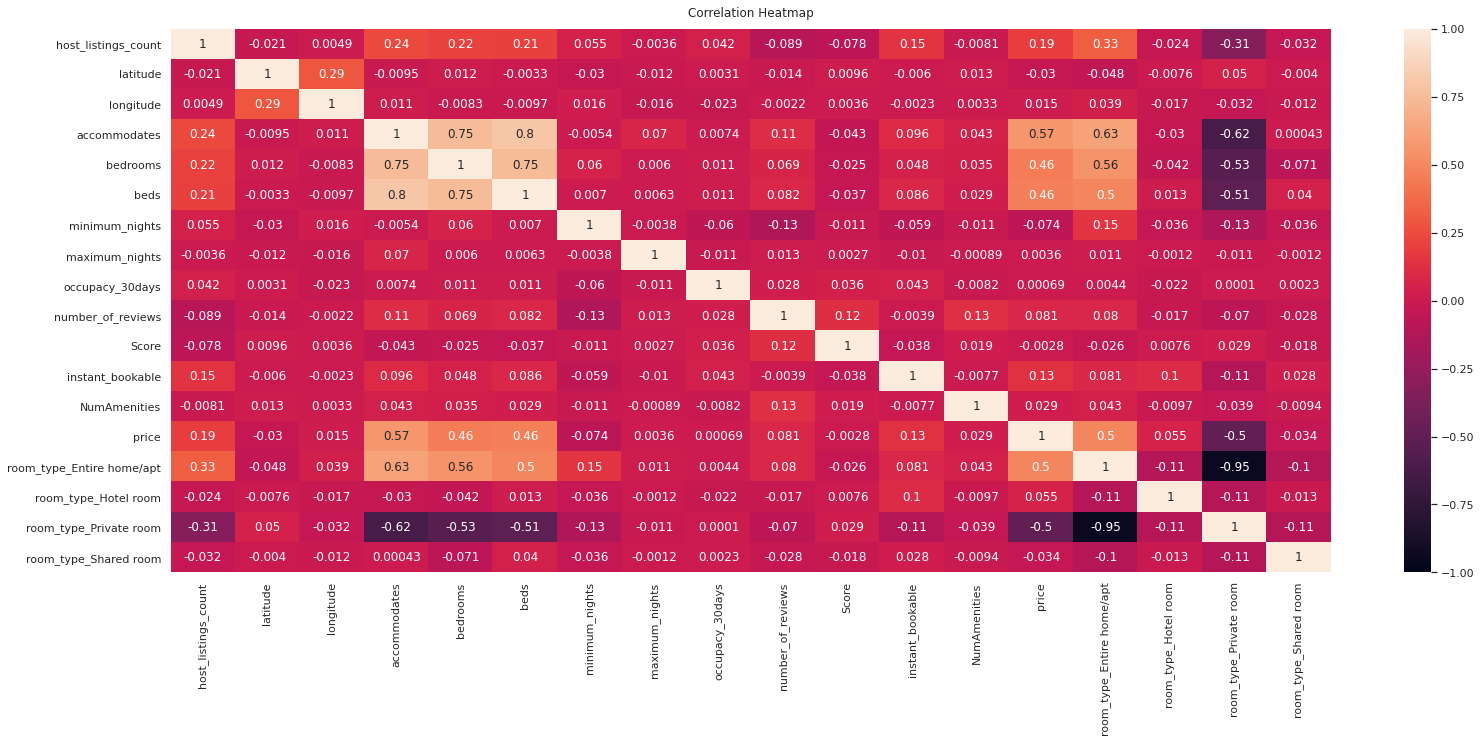

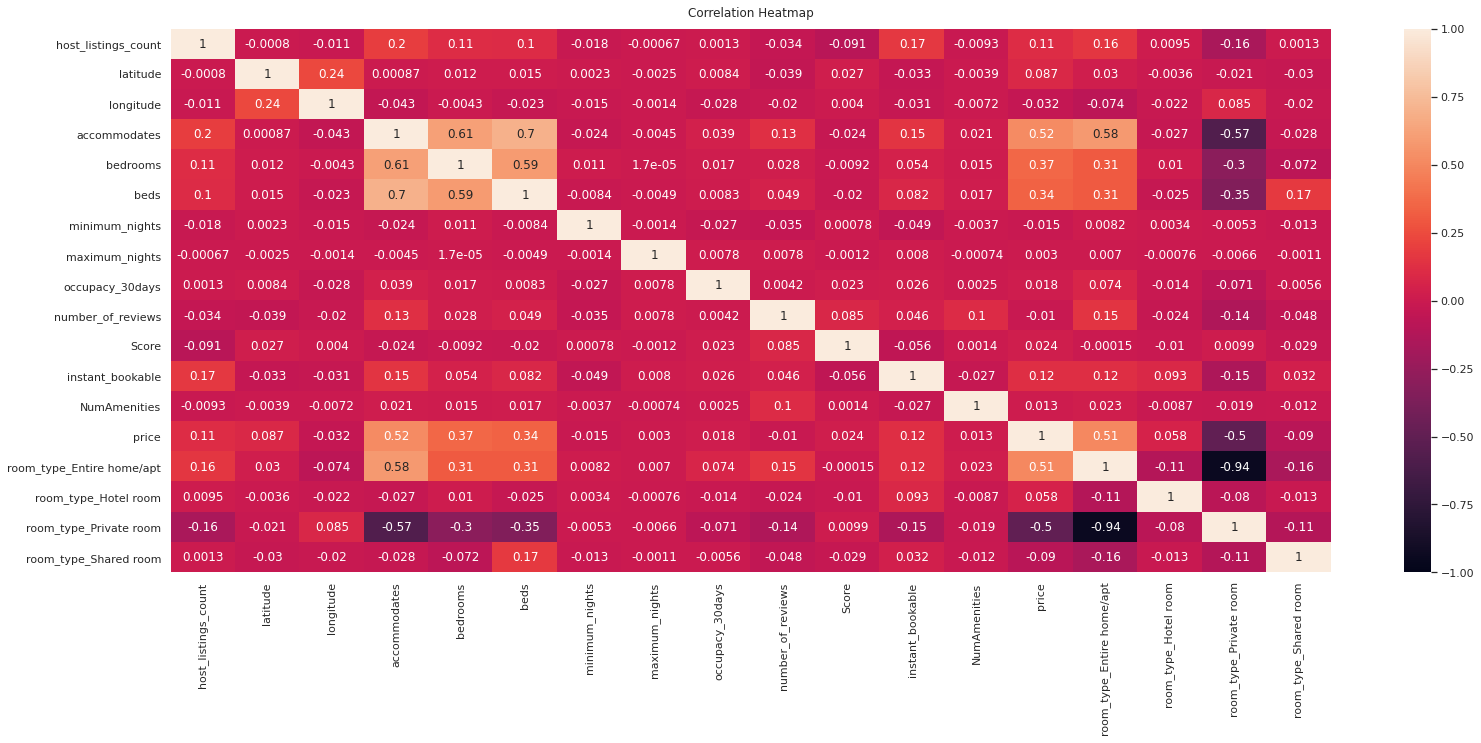

In [56]:
corrMatrix_bcn = df_dummy_bcn.corr()

plt.figure(figsize=(26, 10))
heatmap = sns.heatmap(corrMatrix_bcn, vmin=-1, vmax=1, annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

corrMatrix_mad = df_dummy_mad.corr()

plt.figure(figsize=(26, 10))
heatmap = sns.heatmap(corrMatrix_mad, vmin=-1, vmax=1, annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

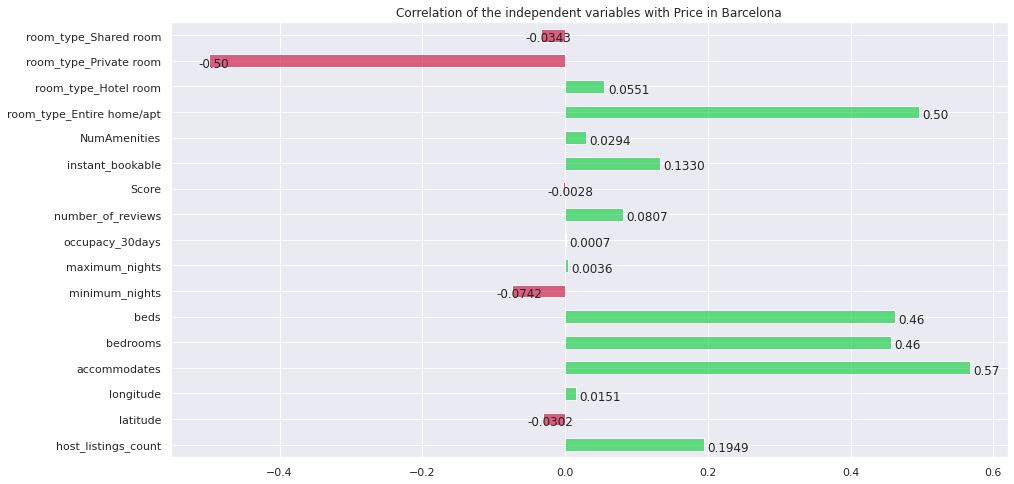

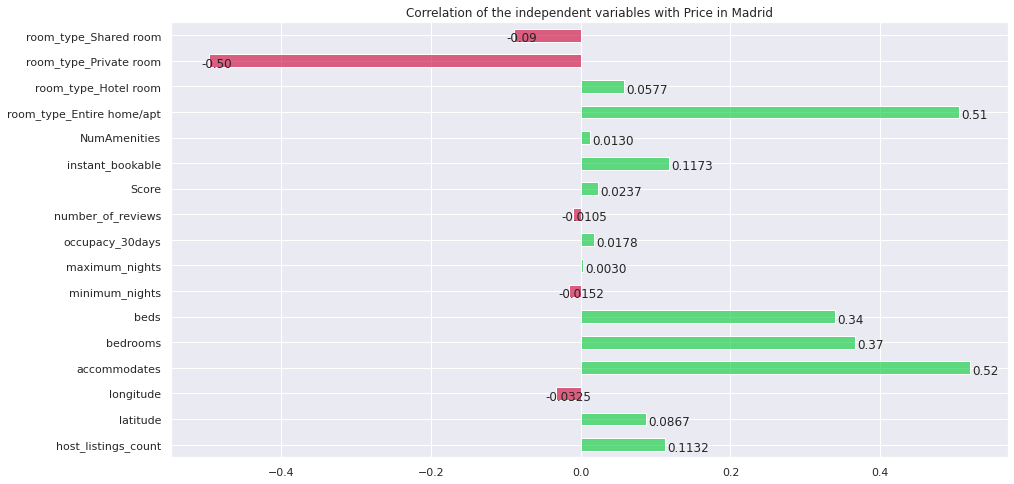

In [57]:
plt.figure("Barcelona", figsize=(15,8))
plt.title("Correlation of the independent variables with Price in Barcelona")
corrMatrix_bcn = df_dummy_bcn.corr()
colors = []
for col in corrMatrix_bcn.price.drop('price'):
    if col < 0:
        colors.append((0.8,0,0.2, 0.6))
    else:
        colors.append((0,0.8,0.2, 0.6))
plot = corrMatrix_bcn.price.drop('price').plot.barh(color=colors)
for p in plot.patches:
    if p.get_width() > 0:
        if p.get_width() > 0.2:
            plot.annotate("{:.2f}".format(p.get_width()), (p.get_width()+.005, p.get_y()))
        else:
            plot.annotate("{:.4f}".format(p.get_width()), (p.get_width()+.005, p.get_y()))
    else:
        if p.get_width() < -0.1:
            plot.annotate("{:.2f}".format(p.get_width()), (p.get_width()-.015, p.get_y()))
        else:
            plot.annotate("{:.4f}".format(p.get_width()), (p.get_width()-.022, p.get_y()))
            
plt.figure("Madrid", figsize=(15,8))
plt.title("Correlation of the independent variables with Price in Madrid")
corrMatrix_mad = df_dummy_mad.corr()
colors = []
for col in corrMatrix_mad.price.drop('price'):
    if col < 0:
        colors.append((0.8,0,0.2, 0.6))
    else:
        colors.append((0,0.8,0.2, 0.6))
plot = corrMatrix_mad.price.drop('price').plot.barh(color=colors)
for p in plot.patches:
    if p.get_width() > 0:
        if p.get_width() > 0.14:
            plot.annotate("{:.2f}".format(p.get_width()), (p.get_width()+.003, p.get_y()))
        else:
            plot.annotate("{:.4f}".format(p.get_width()), (p.get_width()+.003, p.get_y()))
    else:
        if p.get_width() < -0.08:
            plot.annotate("{:.2f}".format(p.get_width()), (p.get_width()-.01, p.get_y()))
        else:
            plot.annotate("{:.4f}".format(p.get_width()), (p.get_width()-.015, p.get_y()))
plt.show()

### Train and test split

In [58]:
x_bcn = df_dummy_bcn.drop(columns = 'price')
y_bcn = df_dummy_bcn.price
x_tr_bcn, x_tst_bcn, y_tr_bcn, y_tst_bcn = train_test_split(x_bcn, y_bcn, test_size=0.33, random_state=42)

x_mad = df_dummy_mad.drop(columns = 'price')
y_mad = df_dummy_mad.price
x_tr_mad, x_tst_mad, y_tr_mad, y_tst_mad = train_test_split(x_mad, y_mad, test_size=0.33, random_state=42)


### Model training

In [59]:
regr_bcn = GradientBoostingRegressor(loss='ls', learning_rate=0.06, n_estimators=100, subsample=1.0, 
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                     min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                     alpha=0.1, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
pipe_bcn = make_pipeline(StandardScaler(), regr_bcn)
pipe_bcn.fit(x_tr_bcn, y_tr_bcn)
score_tr_bcn = pipe_bcn.score(x_tr_bcn, y_tr_bcn)
print("Score train: ", score_tr_bcn)

Score train:  0.8969209983041991


In [60]:
regr_mad = GradientBoostingRegressor(loss='ls', learning_rate=0.06, n_estimators=100, subsample=1.0, 
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                     min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                     alpha=0.1, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
pipe_mad = make_pipeline(StandardScaler(), regr_mad)
pipe_mad.fit(x_tr_mad, y_tr_mad)
score_tr_mad = pipe_mad.score(x_tr_mad, y_tr_mad)
print("Score train: ", score_tr_mad)

Score train:  0.8819655512370563


### Feature importance

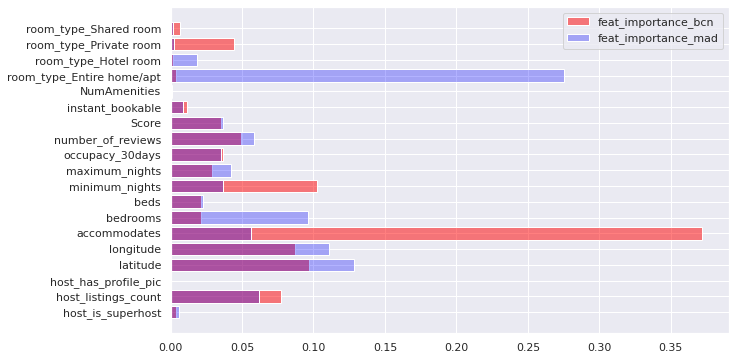

In [61]:
plt.figure(figsize=(10,6))
plt.barh(x_tr_bcn.columns, regr_bcn.feature_importances_, color=(1, 0, 0, 0.5), label="feat_importance_bcn")

# plt.figure(figsize=(6,6))
plt.barh(x_tr_mad.columns, regr_mad.feature_importances_, color=(0, 0, 1, 0.3), label="feat_importance_mad")
plt.legend()
plt.plot();

### Model score prediction

In [62]:
pred_bcn = pipe_bcn.predict(x_tst_bcn)
score_tst_bcn = np.sum((pred_bcn - y_tst_bcn.values))/pred_bcn.shape[0]
print("Score test Barcelona: ", score_tst_bcn, ", R2: ", pipe_bcn.score(x_tst_bcn, y_tst_bcn))

pred_mad = pipe_mad.predict(x_tst_mad)
score_tst_mad = np.sum((pred_mad - y_tst_mad.values))/pred_mad.shape[0]
print("Score test Madrid: ", score_tst_mad, ", R2: ", pipe_mad.score(x_tst_mad, y_tst_mad))

Score test Barcelona:  0.3463973355249935 , R2:  0.5347227018241976
Score test Madrid:  0.25644610529210493 , R2:  0.512610239783648


In [63]:
y_tst_bcn.values

array([138., 104.,  53., ..., 112., 100.,  40.])

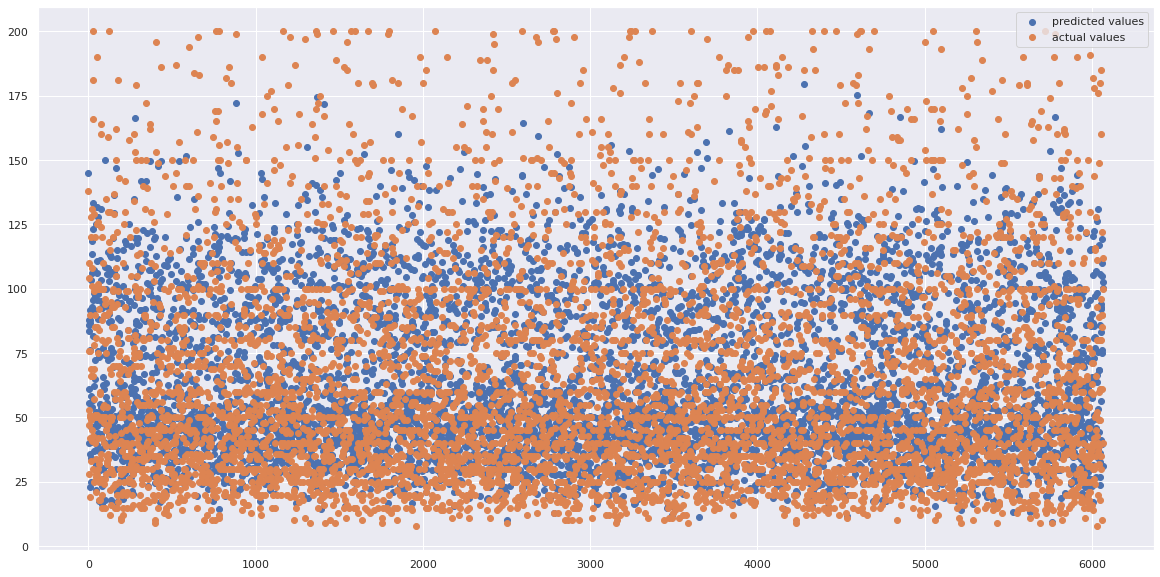

In [64]:
pred_bcn = pipe_bcn.predict(x_tst_bcn)

plt.figure(figsize=(20,10))
plt.scatter(range(pred_bcn[:].shape[0]), pred_bcn[:], label='predicted values')
plt.scatter(range(pred_bcn[:].shape[0]), y_tst_bcn[:].values, label='actual values')
plt.legend()
plt.plot();

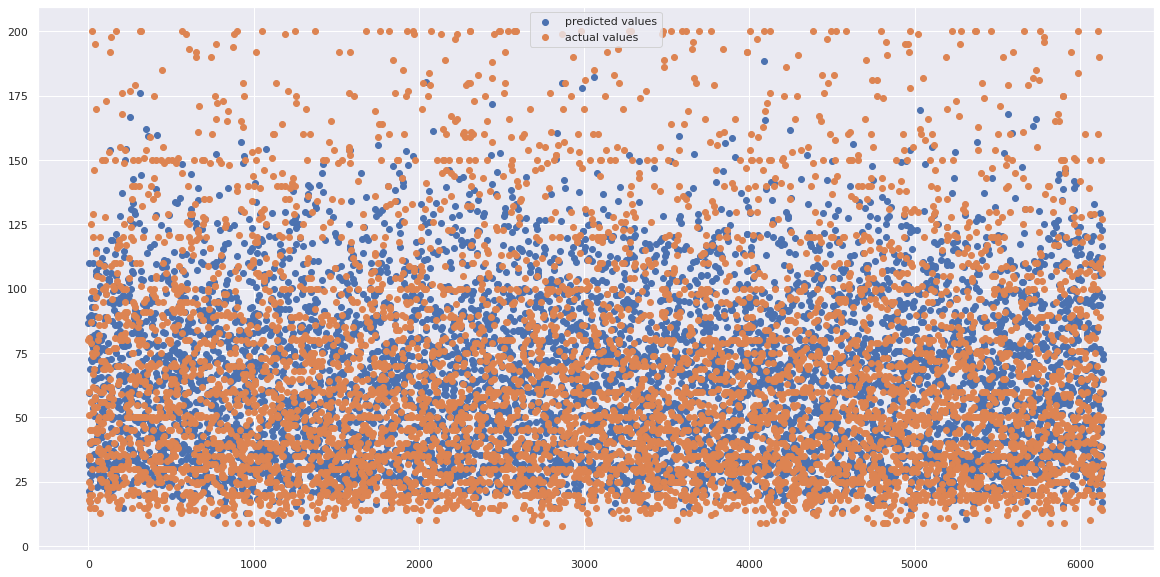

In [65]:
pred_mad = pipe_mad.predict(x_tst_mad)

plt.figure(figsize=(20,10))
plt.scatter(range(pred_mad[:].shape[0]), pred_mad[:], label='predicted values')
plt.scatter(range(pred_mad[:].shape[0]), y_tst_mad[:].values, label='actual values')
plt.legend()
plt.plot();